<a href="https://colab.research.google.com/github/MehrdadJalali-KIT/BlackHole/blob/main/BlackHoleMethod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')
# Change working path
os.chdir('/content/drive/MyDrive/Research/MOF/Black_Hole')

Mounted at /content/drive


In [3]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 41.5 MB/s eta 0:00:00


# Black Hole Strategy for MOF Graphs

In this notebook, we are implementing a **Black Hole Strategy** to refine the graph representation of Metal-Organic Frameworks (MOFs). This approach helps us reduce the complexity of the graph by identifying and removing less influential nodes (MOFs) based on a calculated "gravity" metric. The steps involved in this strategy are as follows:

## 1. Loading the Edge List and Summary Data
We begin by loading the edge list, which defines the relationships (edges) between MOFs (nodes), and the summary data, which contains additional features about the MOFs (such as chemical properties).

- **Edge List**: Contains source and target nodes (MOFs) and their connection weights.
- **Summary Data**: Contains features for each MOF, such as SMILES strings, metal types, and geometric properties like cavity diameter and pore size.

## 2. Constructing the MOF Graph
Using the edge list, we create a graph where each node represents a MOF, and edges represent the relationships between them. This graph allows us to explore the structure and connectivity of the MOFs.

## 3. Detecting Communities
To organize the graph, we apply **community detection**. Communities represent groups of MOFs that are more strongly connected to each other than to other parts of the graph.

- **Girvan-Newman Algorithm**: This algorithm is used to detect communities by iteratively removing edges with high betweenness centrality, splitting the graph into smaller groups.

## 4. Calculating the Gravity Metric
Within each detected community, we calculate a **gravity metric** for each node. This metric combines two centrality measures:
- **Degree Centrality**: Represents how many connections (edges) a node has.
- **Betweenness Centrality**: Represents how often a node acts as a bridge between other nodes in the graph.

The gravity of a node is the sum of its degree and betweenness centrality. Nodes with higher gravity are considered more influential within their communities.

## 5. Applying the Black Hole Strategy
In the Black Hole Strategy, we set a gravity threshold. Nodes (MOFs) with gravity below this threshold are considered less influential and are removed from the graph, along with their associated edges. This results in a "sparsified" graph containing only the most important nodes (black holes) within each community.

## 6. Saving the Sparsified Graph and Features
After removing low-gravity nodes, we save the new edge list of the sparsified graph and the features of the remaining nodes for further analysis. This refined dataset focuses on the most promising MOFs and simplifies future computations.

## 7. Visualizing the Graph
Finally, we visualize the sparsified graph to observe the structure after applying the Black Hole Strategy. The visualization helps us see how the graph has been reduced in complexity and highlights the key communities and their central nodes.

## Benefits of the Black Hole Strategy:
- **Efficiency**: By focusing on the most influential MOFs, we reduce the dataset size and computational cost for further analysis.
- **Clarity**: The resulting graph highlights the most important MOFs, making it easier to identify key candidates for specific applications.


In [ ]:
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings

import pandas as pd
import numpy as np
import networkx as nx
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import networkx.algorithms.community as nx_comm
import time
from rdkit import RDLogger
# Suppress specific deprecation warnings and RDKit warnings globally
warnings.filterwarnings("ignore", category=DeprecationWarning)
RDLogger.DisableLog('rdApp.*')

def load_edges_list(filename):
    """Loads edge list from a CSV file."""
    return pd.read_csv(filename)

from rdkit import Chem
from rdkit.Chem import AllChem

def generate_fingerprint(smiles):
    """Generates a molecular fingerprint given a SMILES string using the older method."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            # Return an array of zeros if the molecule can't be parsed
            print(f"SMILES Parse Error: Unable to parse {smiles}")
            return np.zeros((1024,))

        # Generate the fingerprint using AllChem.GetMorganFingerprintAsBitVect
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
        return np.array(fingerprint)
    except Exception as e:
        # Log other errors that may arise
        print(f"SMILES Parse Error: {e}")
        return np.zeros((1024,))  # Return an array of zeros in case of an error


def label_encode_metal_names(metal_names):
    """Encodes metal names as integers."""
    metal_dict = {metal: idx for idx, metal in enumerate(np.unique(metal_names))}
    return np.array([metal_dict[metal] for metal in metal_names])

def load_summary_data(filename, node_labels):
    """Loads summary data and preprocesses it to extract features."""
    summary_data = pd.read_csv(filename, index_col=0)
    linker_smiles = summary_data['linker SMILES']
    linker_features = np.stack(linker_smiles.apply(generate_fingerprint).values)
    metal_names = summary_data['metal']
    metal_features = label_encode_metal_names(metal_names).reshape(-1, 1)
    other_features = summary_data[['Largest Cavity Diameter', 'Pore Limiting Diameter', 'Largest Free Sphere']].values.astype('float32')
    features = np.concatenate((linker_features, metal_features, other_features), axis=1)
    if len(summary_data) == len(node_labels) and all(label in summary_data.index for label in node_labels):
        return pd.DataFrame(features, index=node_labels)
    else:
        print("Warning: Mismatch between summary data and node labels.")
        return pd.DataFrame(features, index=summary_data.index)

def detect_communities(graph):
    """Detects communities in the graph using the Girvan-Newman algorithm."""
    communities_generator = nx_comm.girvan_newman(graph)
    top_level_communities = next(communities_generator)
    communities = [list(community) for community in top_level_communities]
    return communities

def calculate_gravity_per_community(graph, communities):
    """Calculates gravity for each node within its respective community."""
    community_gravity = {}

    for community in communities:
        subgraph = graph.subgraph(community)
        degree_centrality = nx.degree_centrality(subgraph)
        betweenness_centrality = nx.betweenness_centrality(subgraph)

        for node in community:
            # Gravity is the sum of degree and betweenness centrality
            gravity = degree_centrality[node] + betweenness_centrality[node]
            community_gravity[node] = gravity

    return community_gravity

def black_hole_strategy_per_community(graph, gravity, threshold=0.2):
    """Removes nodes with gravity below a certain threshold and their connected edges in each community."""
    nodes_to_remove = [node for node, grav in gravity.items() if grav < threshold]
    graph.remove_nodes_from(nodes_to_remove)
    return graph

def visualize_graph(graph):
    """Visualizes the graph."""
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_size=50, node_color="skyblue", edge_color="gray")
    plt.title("Visualizing the Graph")
    plt.show()

def save_remaining_node_features(graph, summary_data, filename):
    remaining_nodes = list(graph.nodes())
    remaining_features = summary_data.loc[remaining_nodes]
    remaining_features.to_csv(filename, index=False)
    print(f"Features of the remaining nodes saved to {filename}.")

if __name__ == "__main__":
    start_time = time.time()
    edges_list_filename = 'edges_list_0.8_Full_2.csv'
    summary_data_filename = '1M1L3D_summary.csv'
    output_edges_filename = 'sparsified_graph_edges_blackhole.csv'
    output_features_filename = 'remaining_node_features_blackhole.csv'

    edges_list = load_edges_list(edges_list_filename)
    node_labels = pd.concat([edges_list['source'], edges_list['target']]).unique()
    summary_data = load_summary_data(summary_data_filename, node_labels)

    # Construct the graph
    graph = nx.Graph()
    for _, row in edges_list.iterrows():
        graph.add_edge(row['source'], row['target'], weight=row['weight'])

    # Print number of edges and nodes before applying Black Hole Strategy
    print(f"Before Black Hole Strategy: {graph.number_of_edges()} edges, {graph.number_of_nodes()} nodes.")

    # Step 1: Detect communities
    communities = detect_communities(graph)
    print(f"Number of communities detected: {len(communities)}")

    # Step 2: Calculate gravity for each node within its respective community
    gravity_per_community = calculate_gravity_per_community(graph, communities)

    # Step 3: Apply Black Hole Strategy (remove nodes below gravity threshold)
    graph = black_hole_strategy_per_community(graph, gravity_per_community, threshold=0.2)

    # Save the sparsified edge list
    nx.write_edgelist(graph, output_edges_filename, data=['weight'])

    # Print number of edges and nodes after applying Black Hole Strategy
    print(f"After Black Hole Strategy: {graph.number_of_edges()} edges, {graph.number_of_nodes()} nodes.")
    print(f"Total runtime: {time.time() - start_time} seconds")

    save_remaining_node_features(graph, summary_data, output_features_filename)
    visualize_graph(graph)


In [ ]:
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings
from rdkit import RDLogger
import pandas as pd
import numpy as np
import networkx as nx
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import networkx.algorithms.community as nx_comm
import time
# Suppress specific deprecation warnings and RDKit warnings globally
warnings.filterwarnings("ignore", category=DeprecationWarning)
RDLogger.DisableLog('rdApp.*')

def load_edges_list(filename):
    """Loads edge list from a CSV file."""
    return pd.read_csv(filename)

def generate_fingerprint(smiles):
    """Generates a molecular fingerprint given a SMILES string."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            # Return an array of zeros if the molecule can't be parsed
            print(f"SMILES Parse Error: Unable to parse {smiles}")
            return np.zeros((1024,))

        # Generate the fingerprint using AllChem.GetMorganFingerprintAsBitVect
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
        return np.array(fingerprint)
    except Exception as e:
        # Log other errors that may arise
        print(f"SMILES Parse Error: {e}")
        return np.zeros((1024,))  # Return an array of zeros in case of an error

def label_encode_metal_names(metal_names):
    """Encodes metal names as integers."""
    metal_dict = {metal: idx for idx, metal in enumerate(np.unique(metal_names))}
    return np.array([metal_dict[metal] for metal in metal_names])

def load_summary_data(filename, node_labels):
    """Loads summary data and preprocesses it to extract features."""
    summary_data = pd.read_csv(filename, index_col=0)
    linker_smiles = summary_data['linker SMILES']
    linker_features = np.stack(linker_smiles.apply(generate_fingerprint).values)
    metal_names = summary_data['metal']
    metal_features = label_encode_metal_names(metal_names).reshape(-1, 1)
    other_features = summary_data[['Largest Cavity Diameter', 'Pore Limiting Diameter', 'Largest Free Sphere']].values.astype('float32')
    features = np.concatenate((linker_features, metal_features, other_features), axis=1)

    if len(summary_data) == len(node_labels) and all(label in summary_data.index for label in node_labels):
        return pd.DataFrame(features, index=node_labels)
    else:
        print("Warning: Mismatch between summary data and node labels.")
        return pd.DataFrame(features, index=summary_data.index)

def detect_communities(graph):
    """Detects communities in the graph using the Girvan-Newman algorithm."""
    communities_generator = nx_comm.girvan_newman(graph)
    top_level_communities = next(communities_generator)
    communities = [list(community) for community in top_level_communities]
    print(f"Detected {len(communities)} communities.")
    return communities

def calculate_gravity_per_community(graph, communities):
    """Calculates gravity for each node within its respective community."""
    community_gravity = {}

    for community in communities:
        subgraph = graph.subgraph(community)
        degree_centrality = nx.degree_centrality(subgraph)
        betweenness_centrality = nx.betweenness_centrality(subgraph)

        for node in community:
            # Gravity is the sum of degree and betweenness centrality
            gravity = degree_centrality.get(node, 0) + betweenness_centrality.get(node, 0)
            community_gravity[node] = gravity

    return community_gravity

def black_hole_strategy_per_community(graph, gravity, threshold=0.2):
    """Removes nodes with gravity below a certain threshold and their connected edges in each community."""
    nodes_to_remove = [node for node, grav in gravity.items() if grav < threshold]

    # Debugging: Check if nodes_to_remove is valid
    print(f"Removing {len(nodes_to_remove)} nodes with gravity below {threshold}")

    # Ensure that the nodes are valid
    if all(isinstance(node, (str, int)) for node in nodes_to_remove):
        graph.remove_nodes_from(nodes_to_remove)
    else:
        raise ValueError(f"Invalid nodes detected: {nodes_to_remove}")

    return graph

def visualize_graph(graph):
    """Visualizes the graph."""
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_size=50, node_color="skyblue", edge_color="gray")
    plt.title("Visualizing the Graph")
    plt.show()

def save_remaining_node_features(graph, summary_data, filename):
    remaining_nodes = list(graph.nodes())
    remaining_features = summary_data.loc[remaining_nodes]
    remaining_features.to_csv(filename, index=False)
    print(f"Features of the remaining nodes saved to {filename}.")

if __name__ == "__main__":
    start_time = time.time()
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
    edges_list_filename = 'edges_list_0.8_Full_2.csv'
    summary_data_filename = '1M1L3D_summary.csv'
    edges_list = load_edges_list(edges_list_filename)
    node_labels = pd.concat([edges_list['source'], edges_list['target']]).unique()
    summary_data = load_summary_data(summary_data_filename, node_labels)

    # Construct the graph
    graph = nx.Graph()
    for _, row in edges_list.iterrows():
        graph.add_edge(row['source'], row['target'], weight=row['weight'])

    # Detect communities once outside the loop
    communities = detect_communities(graph)

    for threshold in thresholds:
        print(f"Processing for threshold: {threshold}")
        gravity_per_community = calculate_gravity_per_community(graph, communities)
        graph = black_hole_strategy_per_community(graph, gravity_per_community, threshold)
        output_edges_filename = f'sparsified_graph_edges_blackhole_{threshold}.csv'
        output_features_filename = f'remaining_node_features_blackhole_{threshold}.csv'
        nx.write_edgelist(graph, output_edges_filename, data=['weight'])
        save_remaining_node_features(graph, summary_data, output_features_filename)

    print(f"Total runtime: {time.time() - start_time} seconds")


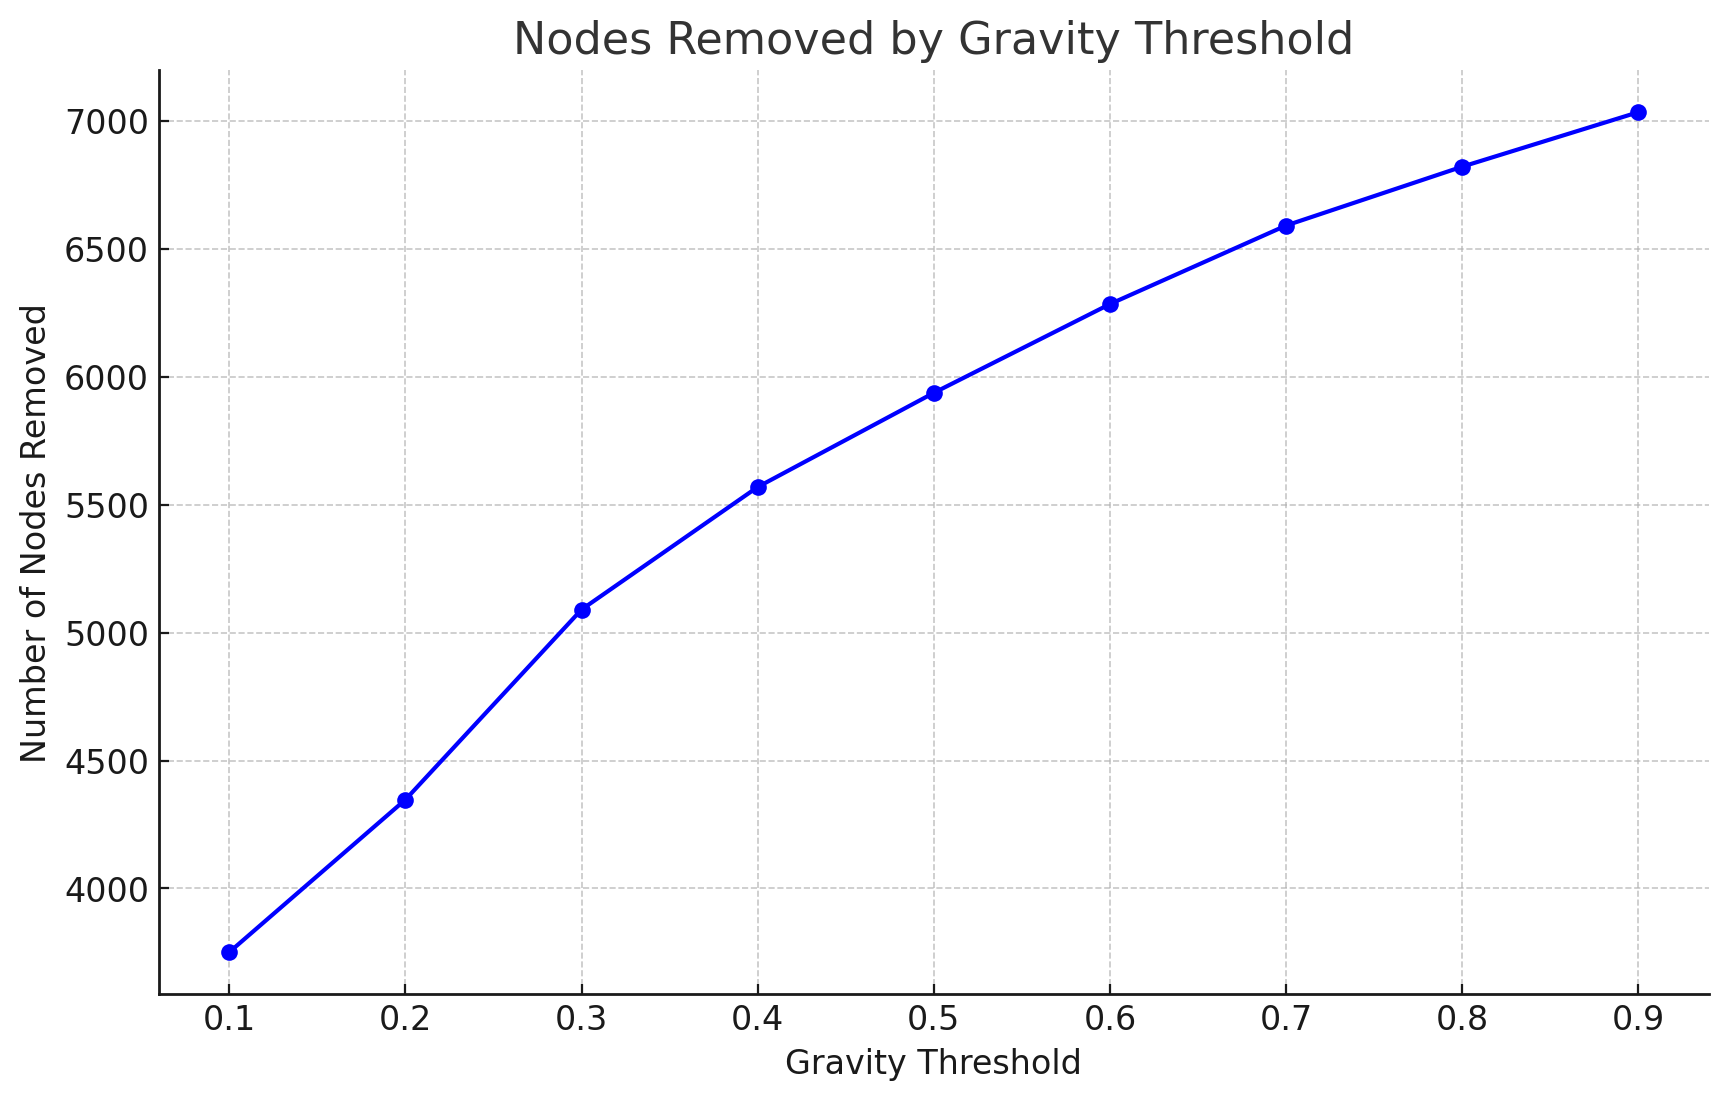

## Influential Node Detection in Network Communities

To identify the most influential nodes within each community in a network, we employ a comprehensive strategy that combines several centrality measures with the connectivity strength of each node. This approach helps in pinpointing nodes that not only hold strategic positions but are also highly connected, thereby playing a crucial role in the structure and dynamics of their communities.

### Methodology

1. **Degree Centrality**: Measures the number of direct connections a node has. Nodes with a high degree centrality can influence their immediate neighbors more significantly.

2. **Betweenness Centrality**: Captures the extent to which a node lies on the shortest path between other nodes in the network. Nodes with high betweenness centrality can control the flow of information within the network, acting as critical conduits between different parts of the network.

3. **Edge Weight Sum**: Reflects the total weight of all edges connected to a node, emphasizing the 'strength' or 'value' of its connections.

### Normalization Strategy

Each of the above metrics is normalized by their maximum values in the subgraph of each community to ensure a fair comparison across diverse network scales and topologies. The final 'gravity' score of each node is then calculated as the sum of these normalized values, providing a single metric to assess the relative influence of nodes within their respective communities.


# Black Hole Strategy for Graph Sparsification

The **Black Hole Strategy** is a graph sparsification technique that progressively removes less important nodes from the graph while retaining the structurally crucial ones. The importance of nodes is quantified by a "gravity" score, which is computed based on multiple centrality metrics. This method ensures that the most central and influential nodes within each community are preserved, while the less connected or influential nodes are removed.

## 1. Community Detection

The first step in the Black Hole Strategy is to partition the graph into disjoint communities. This is done using the Girvan-Newman algorithm, which iteratively removes the edges with the highest betweenness centrality until communities are formed. Each community represents a subgraph of the original graph.

Mathematically, the graph \( G \) is divided into communities \( C_1, C_2, \dots, C_k \), where each community \( C_i \) is a subgraph of \( G \).

\[
C = \{C_1, C_2, \dots, C_k\}, \quad \text{where} \ C_i \subseteq G
\]

## 2. Gravity Calculation

For each node \( v \) in a community \( C_i \), three centrality metrics are calculated to determine its influence within the community:

- **Degree Centrality** \( d(v) \): This measures the number of direct connections a node has, normalized by the number of possible connections.
  
  \[
  d(v) = \frac{\text{deg}(v)}{|C_i| - 1}
  \]

- **Betweenness Centrality** \( b(v) \): This measures how often a node lies on the shortest paths between other nodes in the community.
  
  \[
  b(v) = \frac{ \sum_{s,t \in C_i} \sigma_{st}(v)}{\sigma_{st}}, \quad \text{where} \ \sigma_{st} \ \text{is the number of shortest paths from} \ s \ \text{to} \ t
  \]

- **Edge Weight Sum** \( w(v) \): This metric captures the total weight of edges connected to the node.

  \[
  w(v) = \sum_{(v, u) \in E_i} \text{weight}(v, u), \quad \text{where} \ E_i \ \text{is the set of edges in community} \ C_i
  \]

These three metrics are normalized within each community using **Min-Max Normalization**. The gravity \( g(v) \) of a node is then calculated as the average of the normalized centrality scores:

\[
g(v) = \frac{d'(v) + b'(v) + w'(v)}{3}
\]

Where \( d'(v), b'(v), \text{and } w'(v) \) are the normalized degree, betweenness, and weight sum centralities, respectively.

## 3. Node Removal Based on Gravity

The Black Hole Strategy iteratively removes nodes based on their gravity score. The user defines a threshold \( T \) that controls the proportion of nodes to retain in each community. For example:
- A threshold of \( T = 0.1 \) retains the top 90% of nodes (with the highest gravity) and removes the remaining 10%.
- A threshold of \( T = 0.2 \) retains the top 80% of nodes, and so on.

For each community \( C_i \), the nodes are sorted by their gravity scores in descending order, and the number of nodes to keep is calculated as:

\[
\text{Nodes to Keep} = \lceil (1 - T) \times |C_i| \rceil
\]

Nodes with the lowest gravity are removed, and the graph is updated by removing both the nodes and their associated edges.

## 4. Graph Update

After node removal, the graph \( G \) is updated to reflect the remaining nodes and their edges. The sparsified graph consists of nodes with the highest gravity, ensuring that the structural integrity and centrality of the graph are preserved while reducing its complexity.

## 5. Algorithm Summary

The Black Hole Strategy can be summarized as follows:
1. Partition the graph \( G \) into communities using the Girvan-Newman algorithm.
2. For each node \( v \in C_i \), compute the degree centrality, betweenness centrality, and edge weight sum.
3. Normalize the centrality metrics within each community.
4. Calculate the gravity of each node as the average of the normalized centrality metrics.
5. Remove nodes with the lowest gravity based on a user-defined threshold \( T \).
6. Update the graph by removing the selected nodes and their edges.

By applying the Black Hole Strategy, the graph is progressively sparsified while preserving its most critical nodes, allowing for more efficient analysis and processing of large-scale networks.


In [6]:
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings
from rdkit import RDLogger
import pandas as pd
import numpy as np
import networkx as nx
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
import networkx.algorithms.community as nx_comm
import time

# Suppress specific deprecation warnings and RDKit warnings globally
warnings.filterwarnings("ignore", category=DeprecationWarning)
RDLogger.DisableLog('rdApp.*')

def load_edges_list(filename):
    """Loads edge list from a CSV file."""
    return pd.read_csv(filename)

def generate_fingerprint(smiles):
    """Generates a molecular fingerprint given a SMILES string."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print(f"SMILES Parse Error: Unable to parse {smiles}")
            return np.zeros((1024,))
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024))
    except Exception as e:
        print(f"SMILES Parse Error: {e}")
        return np.zeros((1024,))

def label_encode_metal_names(metal_names):
    """Encodes metal names as integers."""
    metal_dict = {metal: idx for idx, metal in enumerate(np.unique(metal_names))}
    return np.array([metal_dict[metal] for metal in metal_names])

def load_summary_data(filename, node_labels):
    """Loads summary data and preprocesses it to extract features."""
    summary_data = pd.read_csv(filename, index_col=0)
    linker_smiles = summary_data['linker SMILES']
    linker_features = np.stack(linker_smiles.apply(generate_fingerprint).values)
    metal_names = summary_data['metal']
    metal_features = label_encode_metal_names(metal_names).reshape(-1, 1)
    other_features = summary_data[['Largest Cavity Diameter', 'Pore Limiting Diameter', 'Largest Free Sphere']].values.astype('float32')
    features = np.concatenate((linker_features, metal_features, other_features), axis=1)

    return pd.DataFrame(features, index=node_labels if len(summary_data) == len(node_labels) and all(label in summary_data.index for label in node_labels) else summary_data.index)

def detect_communities(graph):
    """Detects communities in the graph using the Girvan-Newman algorithm."""
    communities_generator = nx_comm.girvan_newman(graph)
    top_level_communities = next(communities_generator)
    return [list(community) for community in top_level_communities]

from sklearn.preprocessing import MinMaxScaler

def calculate_gravity_per_community(graph, communities):
    """Calculates normalized gravity per community."""
    community_gravity = {}
    degree_centrality = {}
    betweenness_centrality = {}
    edge_weight_sum = {}

    for community in communities:
        subgraph = graph.subgraph(community)
        degree_centrality_community = nx.degree_centrality(subgraph)
        betweenness_centrality_community = nx.betweenness_centrality(subgraph, normalized=True)
        edge_weight_sum_community = {node: sum(data['weight'] for _, _, data in subgraph.edges(node, data=True)) for node in subgraph.nodes()}

        # Convert values to arrays for normalization
        degree_values = list(degree_centrality_community.values())
        betweenness_values = list(betweenness_centrality_community.values())
        weight_sum_values = list(edge_weight_sum_community.values())

        # Normalize within the community
        scaler = MinMaxScaler()
        normalized_degree = scaler.fit_transform(np.array(degree_values).reshape(-1, 1)).flatten()
        normalized_betweenness = scaler.fit_transform(np.array(betweenness_values).reshape(-1, 1)).flatten()
        normalized_weight_sum = scaler.fit_transform(np.array(weight_sum_values).reshape(-1, 1)).flatten()

        # Assign normalized values and calculate gravity for each node in the community
        for idx, node in enumerate(community):
            degree = normalized_degree[idx]
            betweenness = normalized_betweenness[idx]
            weight_sum = normalized_weight_sum[idx]

            # Gravity is the average of the normalized metrics
            gravity = (degree + betweenness + weight_sum) / 3
            community_gravity[node] = gravity
            degree_centrality[node] = degree_centrality_community[node]
            betweenness_centrality[node] = betweenness_centrality_community[node]
            edge_weight_sum[node] = edge_weight_sum_community[node]

    return community_gravity, degree_centrality, betweenness_centrality, edge_weight_sum




def black_hole_strategy_per_community(graph, gravity, communities, threshold):
    """Removes a percentage of nodes with the lowest gravity in each community based on the threshold."""
    nodes_to_remove = []

    for community in communities:
        # Get nodes in the current community and their gravity scores
        community_nodes = [node for node in community if node in gravity]
        community_gravity_scores = [(node, gravity[node]) for node in community_nodes]

        # Sort the nodes by gravity in descending order (highest gravity first)
        community_gravity_scores.sort(key=lambda x: x[1], reverse=True)

        # Calculate how many nodes to keep based on the threshold
        nodes_to_keep = int((1 - threshold) * len(community_gravity_scores))

        # Identify the nodes to remove (those with the lowest gravity)
        nodes_to_remove.extend([node for node, _ in community_gravity_scores[nodes_to_keep:]])

    # Remove the nodes with lowest gravity from the graph
    graph.remove_nodes_from(nodes_to_remove)
    return graph

def visualize_graph(graph):
    """Visualizes the graph."""
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_size=50, node_color="skyblue", edge_color="gray")
    plt.title("Visualizing the Graph")
    plt.show()

def save_extended_node_features(graph, original_summary_filename, gravity, degree_centrality, betweenness_centrality, edge_weight_sum, filename):
    remaining_nodes = list(graph.nodes())

    # Load the original summary data without any modification
    original_summary_data = pd.read_csv(original_summary_filename, index_col=0)

    # Ensure we keep only the rows corresponding to the remaining nodes
    original_summary_data = original_summary_data.loc[original_summary_data.index.isin(remaining_nodes)]

    # Create a DataFrame for the new features
    metrics_data = pd.DataFrame({
        'refcode': remaining_nodes,
        'Gravity': [gravity.get(node, 0) for node in remaining_nodes],

    })

    # Set 'refcode' as the index for merging
    metrics_data.set_index('refcode', inplace=True)

    # Merge the original summary data with the new metrics data
    final_data = pd.concat([original_summary_data, metrics_data], axis=1)

    # Save the result to the specified file
    final_data.to_csv(filename, index=True)
    print(f"Extended features of the remaining nodes saved to {filename}")

# Main execution
if __name__ == "__main__":
    start_time = time.time()
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
    edges_list_filename = 'edges_list_short.csv'
    # edges_list_filename = 'edges_list_0.8_Full_2.csv'
    summary_data_filename = '1M1L3D_summary.csv'

    edges_list = load_edges_list(edges_list_filename)
    node_labels = pd.concat([edges_list['source'], edges_list['target']]).unique()

    # Load the summary data (processed features will not be used when saving remaining node features)
    summary_data = load_summary_data(summary_data_filename, node_labels)

    # Construct the graph
    graph = nx.Graph()
    for _, row in edges_list.iterrows():
        graph.add_edge(row['source'], row['target'], weight=row['weight'])

    # Detect communities
    communities = detect_communities(graph)

    for threshold in thresholds:
        print(f"Processing for threshold: {threshold}")

        # Reset or redefine the graph with each iteration if needed
        graph = nx.Graph()
        for _, row in edges_list.iterrows():
            graph.add_edge(row['source'], row['target'], weight=row['weight'])

        # Calculate centrality metrics for each community
        gravity_per_community, degree_centrality, betweenness_centrality, edge_weight_sum = calculate_gravity_per_community(graph, communities)

        # Apply the black hole strategy
        graph = black_hole_strategy_per_community(graph, gravity_per_community, communities, threshold)

        # Print the number of remaining nodes after applying the black hole strategy
        print(f"Number of nodes after black hole strategy with threshold {threshold}: {graph.number_of_nodes()}")

        # Save the results
        output_edges_filename = f'sparsified_graph_edges_blackhole_{threshold}.csv'
        output_features_filename = f'remaining_node_features_blackhole_{threshold}.csv'
        nx.write_edgelist(graph, output_edges_filename, data=['weight'])

        # Save extended node features using the original summary data
        save_extended_node_features(graph, summary_data_filename, gravity_per_community, degree_centrality, betweenness_centrality, edge_weight_sum, output_features_filename)

    print(f"Total runtime: {time.time() - start_time} seconds")


KeyboardInterrupt: 

Processing for threshold: 0.1
Number of nodes after black hole strategy with threshold 0.1: 1813
Extended features of the remaining nodes saved to remaining_node_features_blackhole_0.1.csv


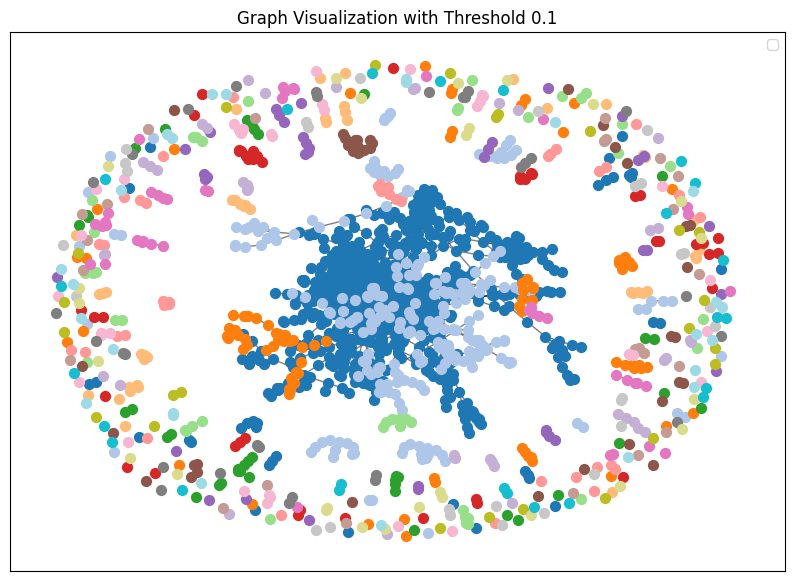

Processing for threshold: 0.2
Number of nodes after black hole strategy with threshold 0.2: 1669
Extended features of the remaining nodes saved to remaining_node_features_blackhole_0.2.csv


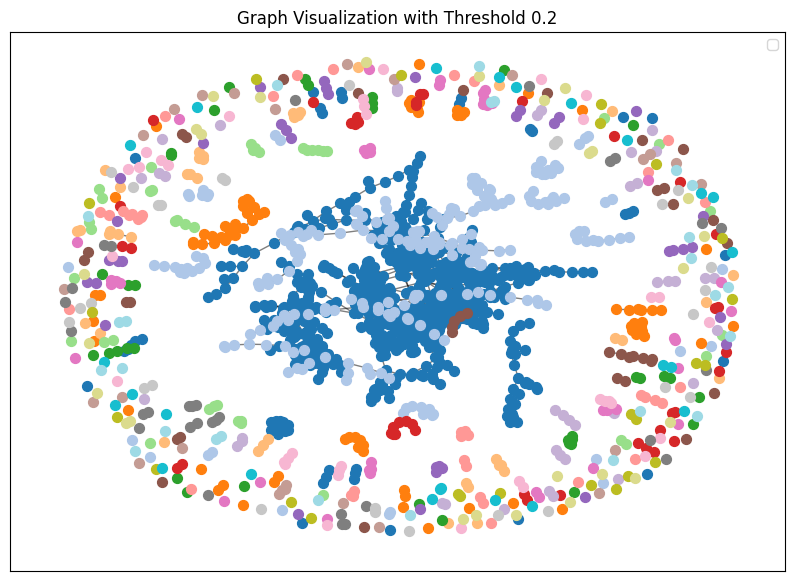

Processing for threshold: 0.3
Number of nodes after black hole strategy with threshold 0.3: 1495
Extended features of the remaining nodes saved to remaining_node_features_blackhole_0.3.csv


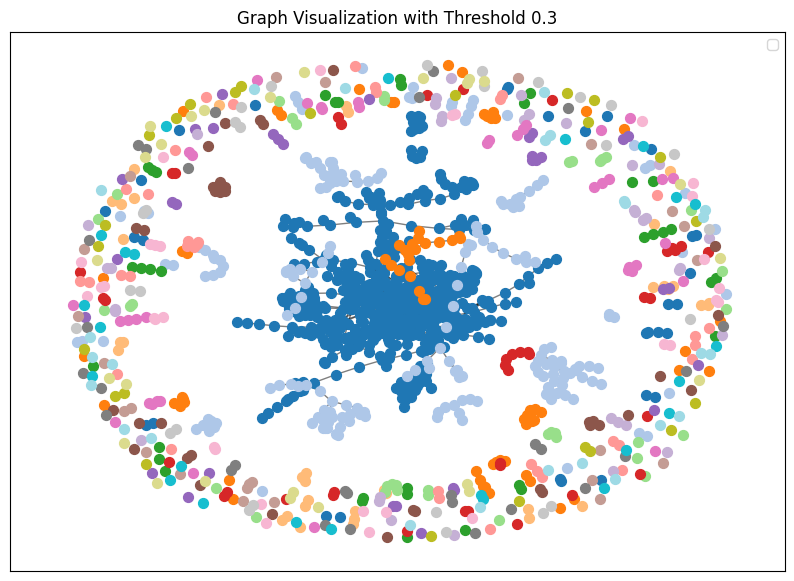

Processing for threshold: 0.4
Number of nodes after black hole strategy with threshold 0.4: 1274
Extended features of the remaining nodes saved to remaining_node_features_blackhole_0.4.csv


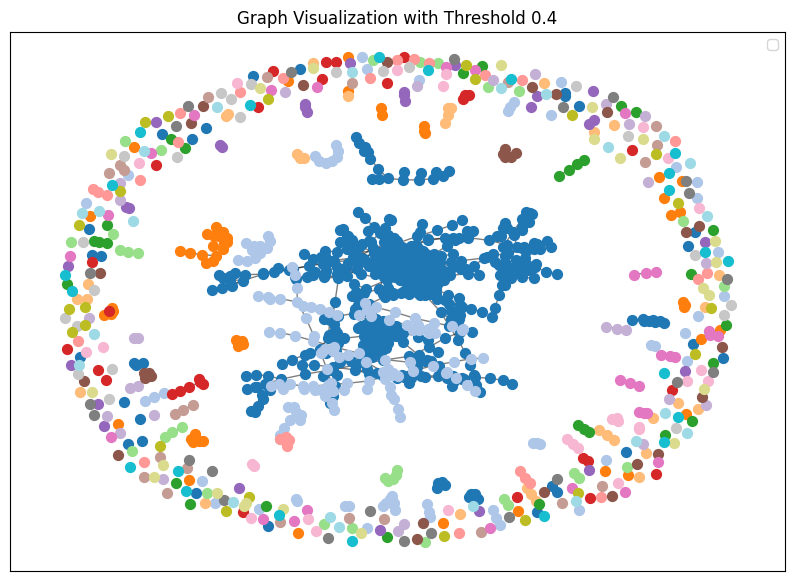

Processing for threshold: 0.5
Number of nodes after black hole strategy with threshold 0.5: 1128
Extended features of the remaining nodes saved to remaining_node_features_blackhole_0.5.csv


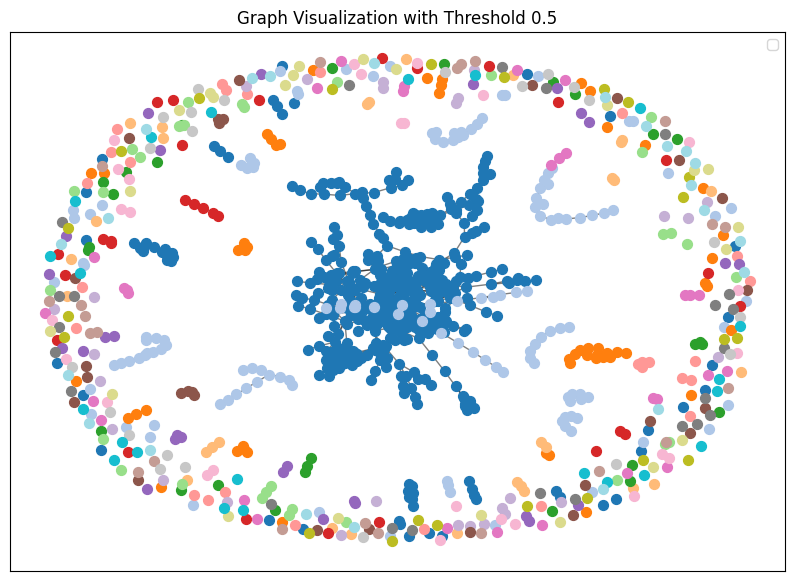

Processing for threshold: 0.6
Number of nodes after black hole strategy with threshold 0.6: 675
Extended features of the remaining nodes saved to remaining_node_features_blackhole_0.6.csv


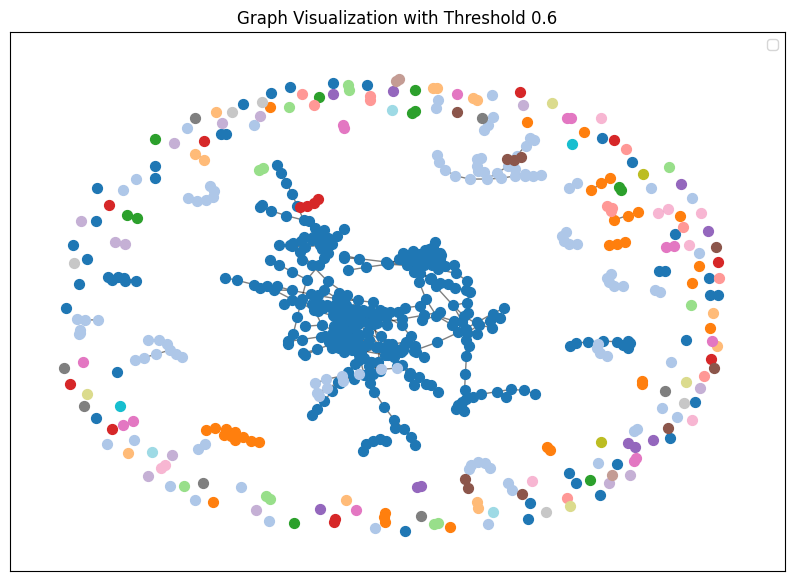

Processing for threshold: 0.7
Number of nodes after black hole strategy with threshold 0.7: 438
Extended features of the remaining nodes saved to remaining_node_features_blackhole_0.7.csv


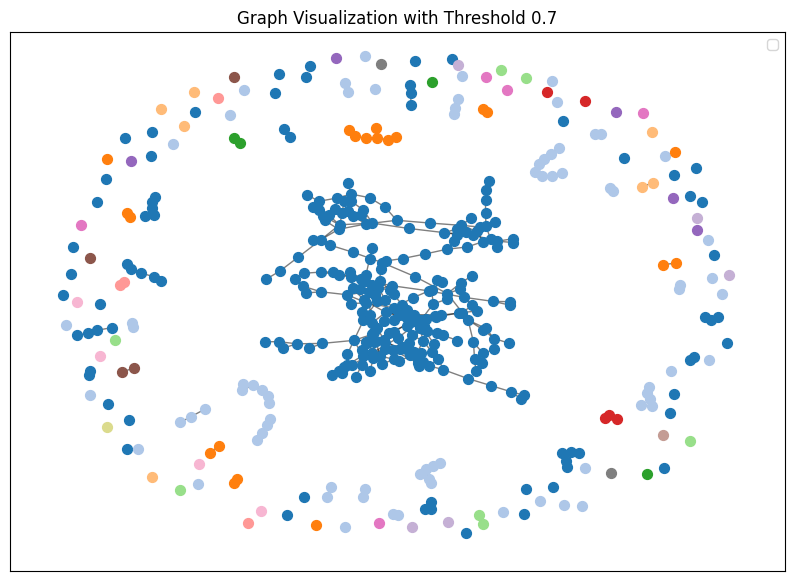

Processing for threshold: 0.8
Number of nodes after black hole strategy with threshold 0.8: 263
Extended features of the remaining nodes saved to remaining_node_features_blackhole_0.8.csv


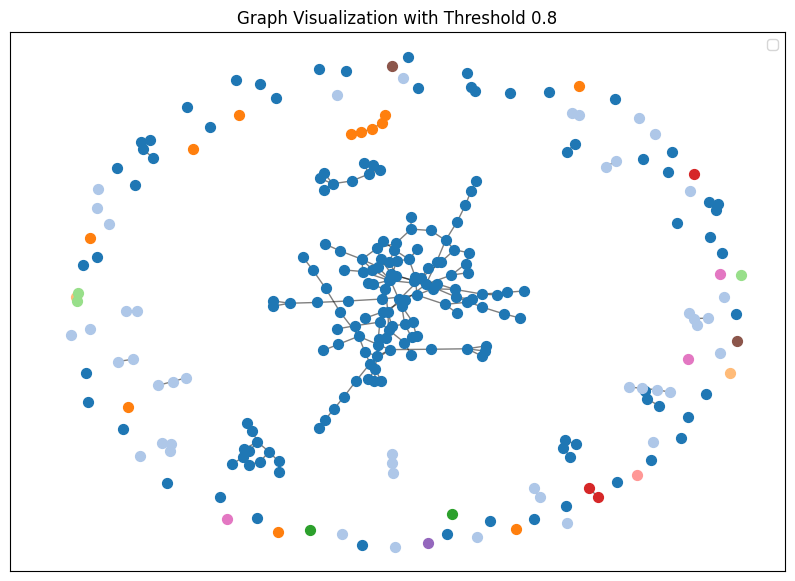

Processing for threshold: 0.9
Number of nodes after black hole strategy with threshold 0.9: 119
Extended features of the remaining nodes saved to remaining_node_features_blackhole_0.9.csv


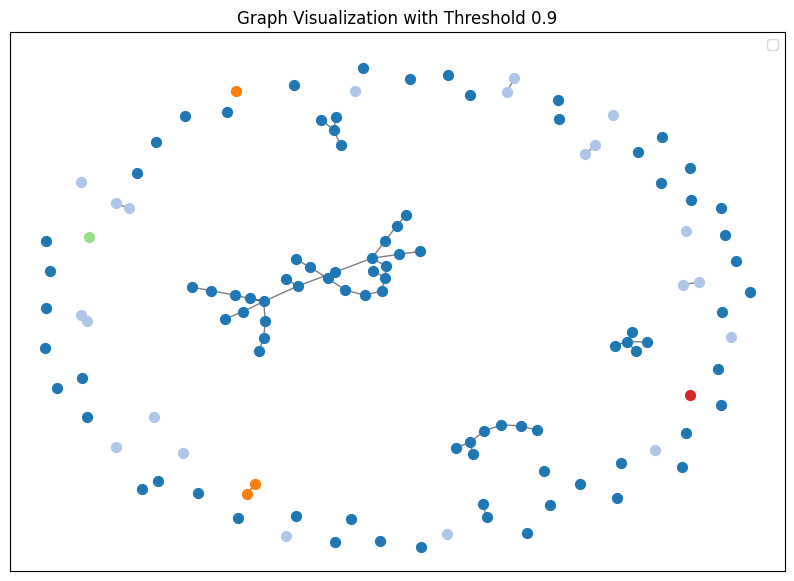

Processing for threshold: 0.95
Number of nodes after black hole strategy with threshold 0.95: 55
Extended features of the remaining nodes saved to remaining_node_features_blackhole_0.95.csv


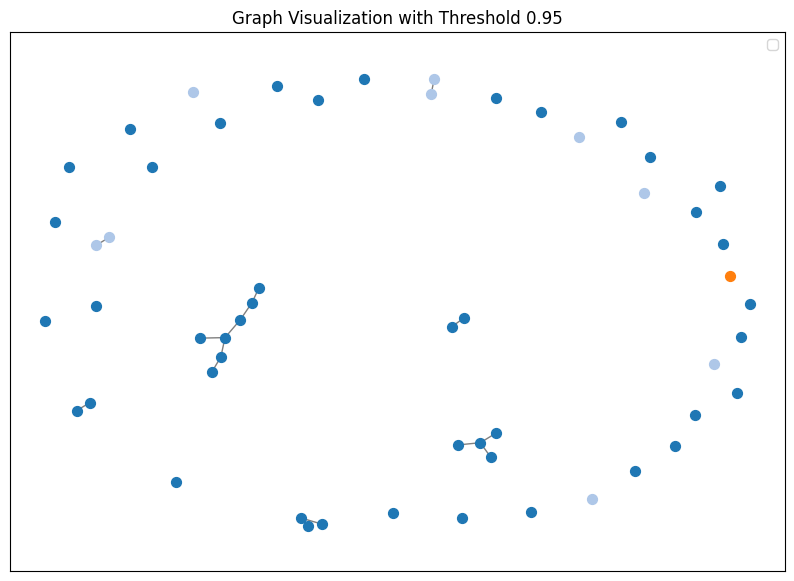

Total runtime: 170.7410478591919 seconds


In [10]:
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings
from rdkit import RDLogger
import pandas as pd
import numpy as np
import networkx as nx
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
import networkx.algorithms.community as nx_comm
import time

# Suppress specific deprecation warnings and RDKit warnings globally
warnings.filterwarnings("ignore", category=DeprecationWarning)
RDLogger.DisableLog('rdApp.*')

def load_edges_list(filename):
    """Loads edge list from a CSV file."""
    return pd.read_csv(filename)

def generate_fingerprint(smiles):
    """Generates a molecular fingerprint given a SMILES string."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print(f"SMILES Parse Error: Unable to parse {smiles}")
            return np.zeros((1024,))
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024))
    except Exception as e:
        print(f"SMILES Parse Error: {e}")
        return np.zeros((1024,))

def label_encode_metal_names(metal_names):
    """Encodes metal names as integers."""
    metal_dict = {metal: idx for idx, metal in enumerate(np.unique(metal_names))}
    return np.array([metal_dict[metal] for metal in metal_names])

def load_summary_data(filename, node_labels):
    """Loads summary data and preprocesses it to extract features."""
    summary_data = pd.read_csv(filename, index_col=0)
    linker_smiles = summary_data['linker SMILES']
    linker_features = np.stack(linker_smiles.apply(generate_fingerprint).values)
    metal_names = summary_data['metal']
    metal_features = label_encode_metal_names(metal_names).reshape(-1, 1)
    other_features = summary_data[['Largest Cavity Diameter', 'Pore Limiting Diameter', 'Largest Free Sphere']].values.astype('float32')
    features = np.concatenate((linker_features, metal_features, other_features), axis=1)

    return pd.DataFrame(features, index=node_labels if len(summary_data) == len(node_labels) and all(label in summary_data.index for label in node_labels) else summary_data.index)

def detect_communities(graph):
    """Detects communities in the graph using the Girvan-Newman algorithm."""
    communities_generator = nx_comm.girvan_newman(graph)
    top_level_communities = next(communities_generator)
    return [list(community) for community in top_level_communities]

from sklearn.preprocessing import MinMaxScaler

def calculate_gravity_per_community(graph, communities):
    """Calculates normalized gravity per community."""
    community_gravity = {}
    degree_centrality = {}
    betweenness_centrality = {}
    edge_weight_sum = {}

    for community in communities:
        subgraph = graph.subgraph(community)
        degree_centrality_community = nx.degree_centrality(subgraph)
        betweenness_centrality_community = nx.betweenness_centrality(subgraph, normalized=True)
        edge_weight_sum_community = {node: sum(data['weight'] for _, _, data in subgraph.edges(node, data=True)) for node in subgraph.nodes()}

        # Convert values to arrays for normalization
        degree_values = list(degree_centrality_community.values())
        betweenness_values = list(betweenness_centrality_community.values())
        weight_sum_values = list(edge_weight_sum_community.values())

        # Normalize within the community
        scaler = MinMaxScaler()
        normalized_degree = scaler.fit_transform(np.array(degree_values).reshape(-1, 1)).flatten()
        normalized_betweenness = scaler.fit_transform(np.array(betweenness_values).reshape(-1, 1)).flatten()
        normalized_weight_sum = scaler.fit_transform(np.array(weight_sum_values).reshape(-1, 1)).flatten()

        # Assign normalized values and calculate gravity for each node in the community
        for idx, node in enumerate(community):
            degree = normalized_degree[idx]
            betweenness = normalized_betweenness[idx]
            weight_sum = normalized_weight_sum[idx]

            # Gravity is the average of the normalized metrics
            gravity = (degree + betweenness + weight_sum) / 3
            community_gravity[node] = gravity
            degree_centrality[node] = degree_centrality_community[node]
            betweenness_centrality[node] = betweenness_centrality_community[node]
            edge_weight_sum[node] = edge_weight_sum_community[node]

    return community_gravity, degree_centrality, betweenness_centrality, edge_weight_sum




def black_hole_strategy_per_community(graph, gravity, communities, threshold):
    """Removes a percentage of nodes with the lowest gravity in each community based on the threshold."""
    nodes_to_remove = []

    for community in communities:
        # Get nodes in the current community and their gravity scores
        community_nodes = [node for node in community if node in gravity]
        community_gravity_scores = [(node, gravity[node]) for node in community_nodes]

        # Sort the nodes by gravity in descending order (highest gravity first)
        community_gravity_scores.sort(key=lambda x: x[1], reverse=True)

        # Calculate how many nodes to keep based on the threshold
        nodes_to_keep = int((1 - threshold) * len(community_gravity_scores))

        # Identify the nodes to remove (those with the lowest gravity)
        nodes_to_remove.extend([node for node, _ in community_gravity_scores[nodes_to_keep:]])

    # Remove the nodes with lowest gravity from the graph
    graph.remove_nodes_from(nodes_to_remove)
    return graph

def visualize_graph(graph):
    """Visualizes the graph."""
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_size=50, node_color="skyblue", edge_color="gray")
    plt.title("Visualizing the Graph")
    plt.show()

def save_extended_node_features(graph, original_summary_filename, gravity, degree_centrality, betweenness_centrality, edge_weight_sum, filename):
    remaining_nodes = list(graph.nodes())

    # Load the original summary data without any modification
    original_summary_data = pd.read_csv(original_summary_filename, index_col=0)

    # Ensure we keep only the rows corresponding to the remaining nodes
    original_summary_data = original_summary_data.loc[original_summary_data.index.isin(remaining_nodes)]

    # Create a DataFrame for the new features
    metrics_data = pd.DataFrame({
        'refcode': remaining_nodes,
        'Gravity': [gravity.get(node, 0) for node in remaining_nodes],

    })

    # Set 'refcode' as the index for merging
    metrics_data.set_index('refcode', inplace=True)

    # Merge the original summary data with the new metrics data
    final_data = pd.concat([original_summary_data, metrics_data], axis=1)

    # Save the result to the specified file
    final_data.to_csv(filename, index=True)
    print(f"Extended features of the remaining nodes saved to {filename}")

import matplotlib.cm as cm
import matplotlib.colors as mcolors

def visualize_graph_with_communities(graph, communities, title):
    """Visualizes the graph with each community in a different color."""
    plt.figure(figsize=(10, 7))

    # Recalculate layout after Black Hole Strategy to avoid missing nodes
    pos = nx.spring_layout(graph)  # Layout for visualization

    # Generate a color map for the communities
    colors = cm.get_cmap('tab20', len(communities))

    # Draw each community in a different color
    for idx, community in enumerate(communities):
        community_nodes = [node for node in community if node in graph.nodes()]  # Ensure nodes are in the graph
        nx.draw_networkx_nodes(
            graph, pos,
            nodelist=community_nodes,  # Only nodes still in the graph
            node_color=[colors(idx)],
            node_size=50,
            # label=f'Community {idx + 1}'
        )

    # Draw the edges
    nx.draw_networkx_edges(graph, pos, alpha=0.5)

    plt.title(title)
    plt.legend()
    plt.show()


# Main execution
if __name__ == "__main__":
    start_time = time.time()
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
    # edges_list_filename = 'edges_list_0.8_Full_2.csv'
    edges_list_filename = 'edges_list_short.csv'
    summary_data_filename = '1M1L3D_summary.csv'

    edges_list = load_edges_list(edges_list_filename)
    node_labels = pd.concat([edges_list['source'], edges_list['target']]).unique()

    # Load the summary data
    summary_data = load_summary_data(summary_data_filename, node_labels)

    # Construct the graph
    graph = nx.Graph()
    for _, row in edges_list.iterrows():
        graph.add_edge(row['source'], row['target'], weight=row['weight'])

    # Detect communities
    communities = detect_communities(graph)

    for threshold in thresholds:
        print(f"Processing for threshold: {threshold}")

        # Reset or redefine the graph with each iteration if needed
        graph = nx.Graph()
        for _, row in edges_list.iterrows():
            graph.add_edge(row['source'], row['target'], weight=row['weight'])

        # Calculate centrality metrics for each community
        gravity_per_community, degree_centrality, betweenness_centrality, edge_weight_sum = calculate_gravity_per_community(graph, communities)

        # Apply the black hole strategy
        graph = black_hole_strategy_per_community(graph, gravity_per_community, communities, threshold)

        # Print the number of remaining nodes after applying the black hole strategy
        print(f"Number of nodes after black hole strategy with threshold {threshold}: {graph.number_of_nodes()}")

        # Save the results
        output_edges_filename = f'sparsified_graph_edges_blackhole_{threshold}.csv'
        output_features_filename = f'remaining_node_features_blackhole_{threshold}.csv'
        nx.write_edgelist(graph, output_edges_filename, data=['weight'])

        # Save extended node features using the original summary data
        save_extended_node_features(graph, summary_data_filename, gravity_per_community, degree_centrality, betweenness_centrality, edge_weight_sum, output_features_filename)

        # Visualize the graph with communities in different colors
        visualize_graph_with_communities(graph, communities, title=f'Graph Visualization with Threshold {threshold}')

    print(f"Total runtime: {time.time() - start_time} seconds")
